In [ ]:
!pip -q install optax

     |████████████████████████████████| 140 kB 14.7 MB/s 
     |████████████████████████████████| 72 kB 377 kB/s 


In [ ]:
import jax.numpy as jnp
import optax
import numpy as np
from jax import random
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [ ]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 36 (delta 18), reused 32 (delta 17), pack-reused 0
Unpacking objects: 100% (36/36), done.
From https://github.com/VLSF/SNO
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [ ]:
from functions import utils, Fourier

# Introduction

In this notebook we explain and test functions from module `utils.py`.

This module provide some convenience wrappers for operations with periodic and non-periodic functions, as well as some functionality of general use.

# Wrappers

Grid for periodic or non-periodic functions.

In [ ]:
utils.grid(5, periodic=True)

DeviceArray([-1. , -0.6, -0.2,  0.2,  0.6], dtype=float64)

In [ ]:
utils.grid(5)

DeviceArray([-1.00000000e+00, -7.07106781e-01,  6.12323400e-17,
              7.07106781e-01,  1.00000000e+00], dtype=float64)

Integration and differentiation

In [ ]:
x = random.normal(random.PRNGKey(12), (13, 12, 11, 2))

y = utils.integrate(x, 1, periodic=False)

z = utils.integrate(x, 1, periodic=True)

In [ ]:
x = random.normal(random.PRNGKey(12), (13, 12, 11, 2))

y = utils.differentiate(x, 1, periodic=False)

z = utils.differentiate(x, 1, periodic=True)

values to coefficients

In [ ]:
x = random.normal(random.PRNGKey(12), (13, 12, 11, 2))

y = utils.values_to_coefficients(x, periodic=False)

z = utils.values_to_coefficients(x, periodic=True)

# Tools for reshaping

Align shape for given axes.

For `mode = "min"` one obtains shapes that are alight for given axes.

In [ ]:
s1 = random.normal(random.PRNGKey(12), (11, 12, 14, 15, 16))
s2 = random.normal(random.PRNGKey(11), (1, 2, 3, 4, 5))

z = utils.align_shapes(s1, s2, ((0, 1, 2), (0, 1, 2)), mode="min")
z

((1, 2, 3, 15, 16), (1, 2, 3, 4, 5))

Using these shapes we can truncate.

In [ ]:
print(utils.truncate(s1, z[0]).shape)
print(utils.truncate(s2, z[1]).shape)

(1, 2, 3, 15, 16)
(1, 2, 3, 4, 5)


For `mode = "max"` one obtains tuples that show how tensors should be expanded.

In [ ]:
w = utils.align_shapes(s1, s2, ((0, 1, 2), (0, 1, 2)), mode="max")
w

(((0, 0), (0, 0), (0, 0), (0, 0), (0, 0)),
 ((0, 10), (0, 10), (0, 11), (0, 0), (0, 0)))

Using the result, we can expand.

In [ ]:
print(utils.expand(s1, w[0]).shape)
print(utils.expand(s2, w[1]).shape)

(11, 12, 14, 15, 16)
(11, 12, 14, 4, 5)


# Activation

Softplus is a usual softplus.

In [ ]:
x = jnp.linspace(-1, 1, 5)

utils.softplus(x)

DeviceArray([0.31326169, 0.47407698, 0.69314718, 0.97407698, 1.31326169],            dtype=float64)

ReLU is a usual ReLU

In [ ]:
x = jnp.linspace(-1, 1, 5)

utils.relu(x)

DeviceArray([0. , 0. , 0. , 0.5, 1. ], dtype=float64)

Activation applied to coefficients:

1. Pad with zeros (= interpolation)
2. Translate to x space
3. Apply activation
4. Go back to the space of coefficients

In [ ]:
coeff = random.normal(random.PRNGKey(12), (11, 12, 14, 16))

print(utils.activation_v(coeff, utils.softplus, 20).shape)
print(utils.activation_v(coeff, utils.softplus, 20, True).shape)

(31, 32, 34, 16)
(31, 32, 34, 16)


In [ ]:
f = lambda x: jnp.cos(3*jnp.pi*x)

x = utils.grid(20, periodic=True).reshape(-1, 1)
values = f(x)
coefficients = utils.values_to_coefficients(values, periodic=True)

coeff_transformed_10 = utils.activation_v(coefficients, lambda x: x*(x>0), 10, True)
coeff_transformed_20 = utils.activation_v(coefficients, lambda x: x*(x>0), 20, True)
coeff_transformed_30 = utils.activation_v(coefficients, lambda x: x*(x>0), 30, True)

values_transformed_10 = Fourier.coefficients_to_values(coeff_transformed_10, (2*(coeff_transformed_10.shape[0]-1), 1))
x_10 =  utils.grid(values_transformed_10.shape[0], periodic=True).reshape(-1, 1)

values_transformed_20 = Fourier.coefficients_to_values(coeff_transformed_20, (2*(coeff_transformed_20.shape[0]-1), 1))
x_20 =  utils.grid(values_transformed_20.shape[0], periodic=True).reshape(-1, 1)

values_transformed_30 = Fourier.coefficients_to_values(coeff_transformed_30, (2*(coeff_transformed_20.shape[0]-1), 1))
x_30 =  utils.grid(values_transformed_30.shape[0], periodic=True).reshape(-1, 1)

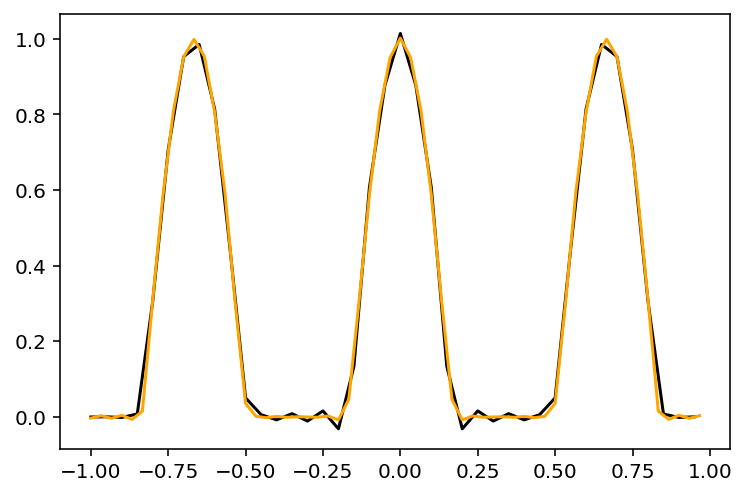

In [ ]:
plt.plot(x_10, values_transformed_10,  color="black")
plt.plot(x_20, values_transformed_20, color="orange");

# Update parameters

Convenience function that update parameters, using optax library.

In [ ]:
from architectures import SNO_1D as vanilla, FNO_1D as fno
from datasets import Indefinite_Integrals

## SNO

In [ ]:
# generate dataset
N_samples = 500
Data = Indefinite_Integrals.Fourier_series(30, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2)

train = (jnp.expand_dims(Data[0][:250], axis=-1), jnp.expand_dims(Data[1][:250], axis=-1))
test = (jnp.expand_dims(Data[0][250:], axis=-1), jnp.expand_dims(Data[1][250:], axis=-1))

In [ ]:
# initialize vanilla neural network
params_encoder = vanilla.init_c_network_params([1, 10, 10], random.PRNGKey(11))
params_i = vanilla.init_i_network_params([50, 50, 50, 50], [10, 10, 10, 10], random.PRNGKey(11))
params_decoder = vanilla.init_c_network_params([10, 1], random.PRNGKey(11))
params_vanilla = [params_encoder, params_i, params_decoder]

vanilla.count_params(params_vanilla)

9441

In [ ]:
# initialize optimizer
sc = optax.exponential_decay(0.01, 1000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params_vanilla)

In [ ]:
%timeit utils.update_params(params_vanilla, train[0], train[1], optimizer, opt_state, vanilla.loss)

The slowest run took 52.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 38 ms per loop


## FNO

In [ ]:
# generate dataset
N_samples = 500
Data = Indefinite_Integrals.Fourier_series(30, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2, return_coefficients=False)

x = jnp.stack([utils.grid(50, periodic=True)]*1000, 0)
train_fno = (jnp.stack([x[:250], Data[0][:250]], -1), jnp.expand_dims(Data[1][:250], -1))
test_fno = (jnp.stack([x[250:], Data[0][250:]], -1), jnp.expand_dims(Data[1][250:], -1))

In [ ]:
sizes_in = [2, 12]
sizes_out = [12, 12, 1]
key = random.PRNGKey(22)
key1, key2, key3 = random.split(key, 3)
params_in = fno.init_c_network_params(sizes_in, key1)
params_out = fno.init_c_network_params(sizes_out, key2)

sizes_fno = [12, 12, 12, 12, 12]
complexities_fno = [14, 14, 14, 14, 14]

params_fno = fno.init_i_network_params(sizes_fno, complexities_fno, key3)

params_1 = [params_in, params_fno, params_out]

sc = optax.exponential_decay(0.01, 1000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params_1)

In [ ]:
%timeit utils.update_params(params_1, train_fno[0], train_fno[1], optimizer, opt_state, fno.loss)

The slowest run took 60.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 59.9 ms per loop


# Interpolation

This is how one can evaluate function presented as a Fourier Series on a Chebyshev grid.

In [ ]:
x = utils.grid(100, periodic=True)
f = jnp.exp(jnp.cos(5*jnp.pi*x)).reshape(-1, 1)
coeff = utils.values_to_coefficients(f, periodic=True)
y = utils.grid(100)
G = jnp.exp(jnp.cos(5*jnp.pi*y)).reshape(-1, 1)

W = utils.get_interpolation_matrix_F(y, coeff.shape[0], is_real=True)

coeff_ = jnp.vstack([coeff, jnp.conj(coeff[1:, :])[::-1, :]])
interpolated = jnp.real(jnp.dot(W, coeff_))

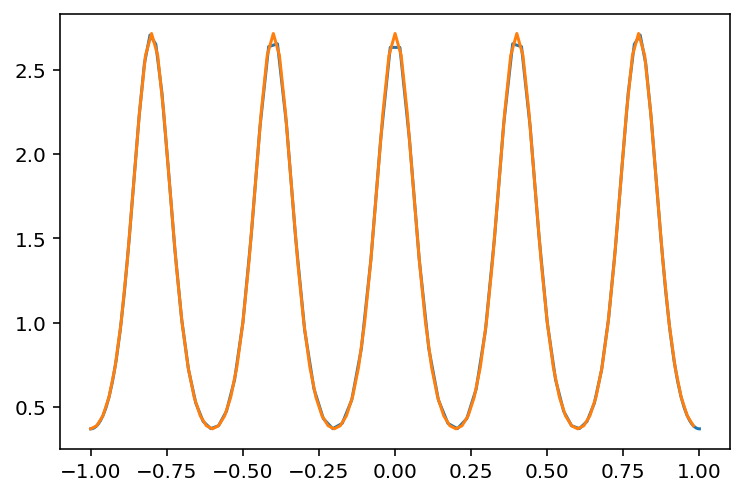

In [ ]:
plt.plot(y, interpolated)
plt.plot(x, f);

In [ ]:
error = jnp.linalg.norm(G - interpolated, jnp.inf)
error

DeviceArray(5.50694212e-10, dtype=float64)